# 最简版：按工单号展示审核通过/不通过图片

只需设置 `GROUP_DATA_BASE` 和 `GROUP_ID`。


/tmp/ipykernel_4071563/3934319504.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])


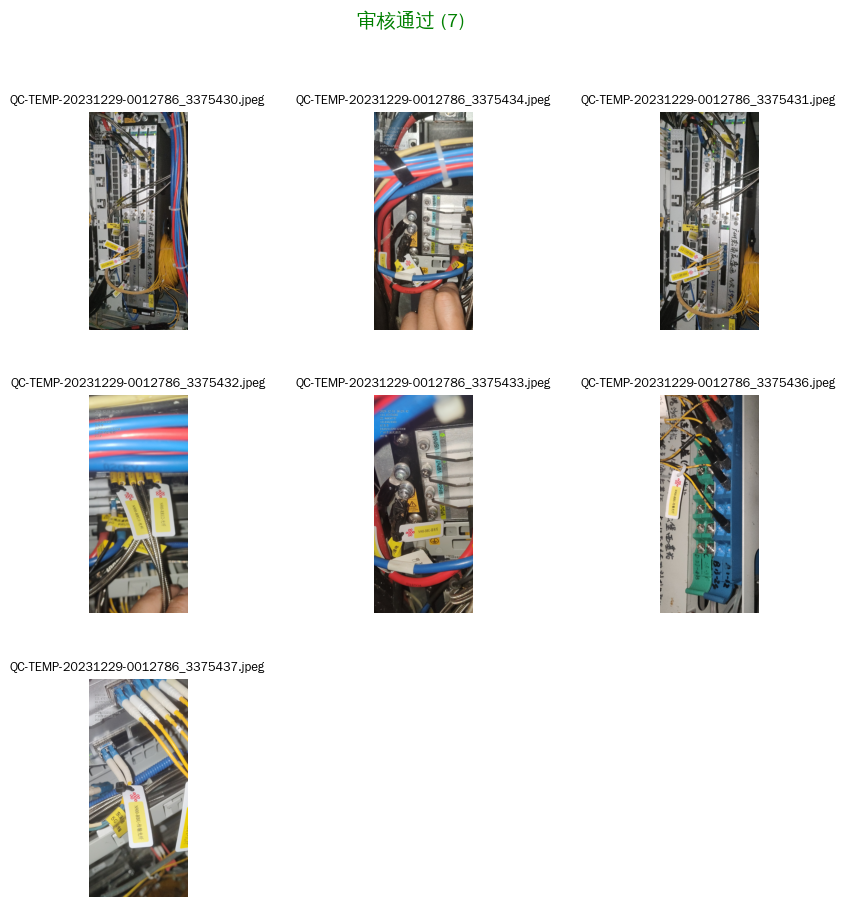

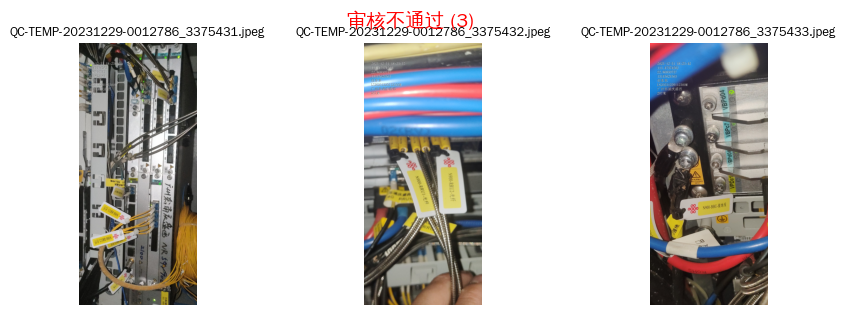

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image as PILImage

# ======= 配置 =======
GROUP_DATA_BASE = Path('/data/Qwen3-VL/group_data')
GROUP_ID = 'QC-TEMP-20230823-0009623'
MAX_PER_CLASS = 64
COLS = 3  # 每行显示多少张

IMG_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp'}

def _is_image(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in IMG_EXTS

def _collect_images(d: Path):
    if not d.exists() or not d.is_dir():
        return []
    return sorted([p for p in d.iterdir() if _is_image(p)])

def _show_grid(images, title, cols=4, title_color='black'):
    if not images:
        return
    n = len(images)
    cols = max(1, min(cols, n))
    rows = (n + cols - 1) // cols

    fig = plt.figure(figsize=(cols * 3.4, rows * 3.4))
    gs = gridspec.GridSpec(rows, cols, figure=fig, hspace=0.3, wspace=0.3)

    for idx, p in enumerate(images):
        ax = fig.add_subplot(gs[idx // cols, idx % cols])
        try:
            img = PILImage.open(p)
            ax.imshow(img)
            ax.set_title(p.name, fontsize=9, fontweight='bold')
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f'加载失败\n{p.name}\n{e}', ha='center', va='center', fontsize=8)
            ax.axis('off')

    fig.suptitle(f'{title} ({n})', fontsize=14, fontweight='bold', y=0.98, color=title_color)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 在 group_data 下查找工单号目录
pass_dirs = []
fail_dirs = []
for d in GROUP_DATA_BASE.rglob(GROUP_ID):
    if not d.is_dir():
        continue
    parts = set(d.parts)
    if '审核通过' in parts:
        pass_dirs.append(d)
    elif '审核不通过' in parts:
        fail_dirs.append(d)

pass_imgs = []
fail_imgs = []
for d in pass_dirs:
    pass_imgs.extend(_collect_images(d))
for d in fail_dirs:
    fail_imgs.extend(_collect_images(d))

if MAX_PER_CLASS and MAX_PER_CLASS > 0:
    pass_imgs = pass_imgs[:MAX_PER_CLASS]
    fail_imgs = fail_imgs[:MAX_PER_CLASS]

if pass_imgs:
    _show_grid(pass_imgs, '审核通过', cols=COLS, title_color='green')
if fail_imgs:
    _show_grid(fail_imgs, '审核不通过', cols=COLS, title_color='red')

if not pass_imgs and not fail_imgs:
    print('未找到包含审核通过/审核不通过的图片目录，请检查 GROUP_ID 或目录结构。')
